# Multi Linear Regression

The following notebook showcases implementation to do a linear regression model. <br>

This notebook is divided into the following:
1. Linear regression model constructions
2. Current approach limitations
3. Feature scaling

This notebooks assume the reader knows how to setup data in a matrix format, what is a multi linear regression, how the cost function is calculated for a multi linear regression model, how feature scaling helps contour plots with gradient descent algorithm, and finally evaluation of overfitting and underfitting the model.

### 1. Overfitting experiments

We will start by understanding when our model happens to be overfitting. To do this, lets run some experiments using linear regression.

In [104]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [105]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import warnings #supress warnings
warnings.filterwarnings("ignore")

### Import the housing data

In [106]:
#Get the data path and obtain housing
data_path = os.path.join(os.getcwd(), os.pardir, "data", "Housing.csv")
print(os.path.exists(data_path))
df_housing = pd.read_csv(data_path)
df_housing.head()

True


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


### Convert everything to numerical

In [107]:
# data preparation

### NOW LETS do the following, lets replace the binary variables to numbers 
# single binomial bernoulli counts
df_housing["mainroad"] = df_housing["mainroad"].replace({"yes": 1, "no": 0})
df_housing["guestroom"] = df_housing["guestroom"].replace({"yes": 1, "no": 0})
df_housing["basement"] = df_housing["basement"].replace({"yes": 1, "no": 0})
df_housing["hotwaterheating"] = df_housing["hotwaterheating"].replace({"yes": 1, "no": 0})
df_housing["airconditioning"] = df_housing["airconditioning"].replace({"yes": 1, "no": 0})
df_housing["parking"] = df_housing["parking"].replace({"yes": 1, "no": 0})
df_housing["prefarea"] = df_housing["prefarea"].replace({"yes": 1, "no": 0})
df_housing["furnishingstatus"] = df_housing["furnishingstatus"].replace({"furnished": 1, "semi-furnished": 1, "unfurnished": 0})

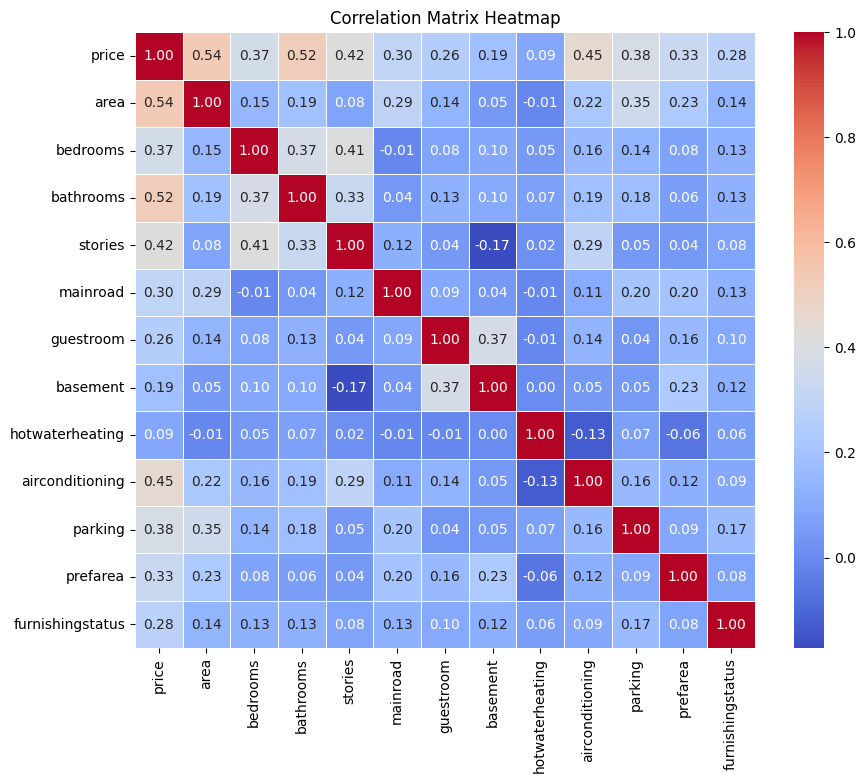

In [108]:
### Create a correlation matrix
correlation_matrix = df_housing.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### lets select the features that have corr coefficient higher than 0.35

In [109]:
# Find the high correlation columns
high_corr_columns = correlation_matrix.columns[(correlation_matrix.iloc[0,:].abs() > 0.35)]
# Select these columns from your original DataFrame
filtered_df = df_housing[high_corr_columns]

# Display the filtered DataFrame with the selected columns
print(filtered_df.shape)
print(filtered_df.head())

(545, 7)
      price  area  bedrooms  bathrooms  stories  airconditioning  parking
0  13300000  7420         4          2        3                1        2
1  12250000  8960         4          4        4                1        3
2  12250000  9960         3          2        2                0        2
3  12215000  7500         4          2        2                1        3
4  11410000  7420         4          1        2                1        2


### Univariate regression
Lets do univariate regession using area and price for the house.

In [110]:
df_uni_variate = filtered_df.loc[:, ["area", "price"]]
df_uni_variate.head()

,area,price
0,7420,13300000
1,8960,12250000
2,9960,12250000
3,7500,12215000
4,7420,11410000


### Feature scaling
Lets min max scale everything and see its disitributions to see how it behaves

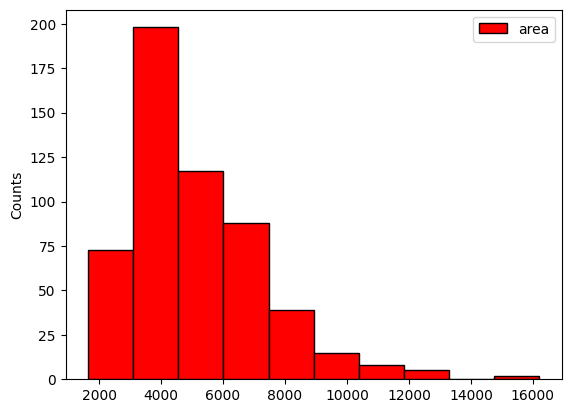

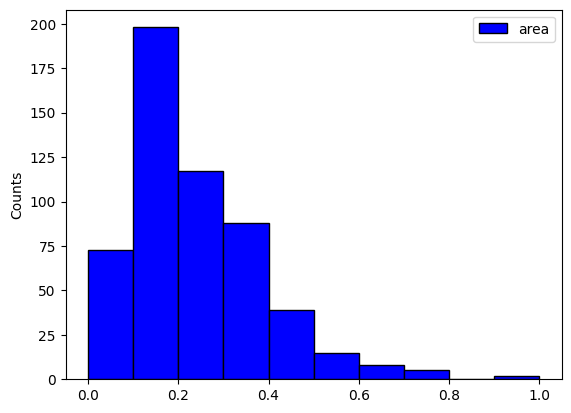

In [111]:
# Lets iterate across columns
def plot_histograms(df:pd.DataFrame, color_plot:str)->None:

    if len(df.columns) > 1:
        fig, axs = plt.subplots(len(df.columns))
        for i, c in enumerate(df.columns):
            axs[i].hist(df[c].to_numpy(), label = str(c),\
                color = color_plot, edgecolor = "black")
            axs[i].legend(loc = "upper right")
            axs[i].set_ylabel("Counts")
    else:
        fig, axs = plt.subplots(1)
        axs.hist(df[df.columns[0]].to_numpy(), label = str(df.columns[0]),\
            color = color_plot, edgecolor = "black")
        axs.legend(loc = "upper right")
        axs.set_ylabel("Counts")
    fig.show()

#Lets used the min-max feature scaled data
x = df_uni_variate.loc[:, df_uni_variate.columns != "price"]
y = pd.DataFrame(df_uni_variate["price"])

#Plot the histograms unnormalized
plot_histograms(df=x, color_plot="r")

#Plot the max feature scaled
x_columns = x.columns
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

# rename columns (since now its an np array)
x = pd.DataFrame(x)
x.columns = x_columns
x.head()

# df_uni_variate = pd.concat([x, y])
# print(df_uni_variate)

#Plot the histograms normalized
plot_histograms(df=x, color_plot="b")

Interesting! The price follows a skewed distribution! meaning a good GLM model to fit could be gamma regression (for continous and skewed data). For now lets continue using normal linear regression and see how it behaves.

### Scatter plot area-price relationships

<Axes: xlabel='area', ylabel='price'>

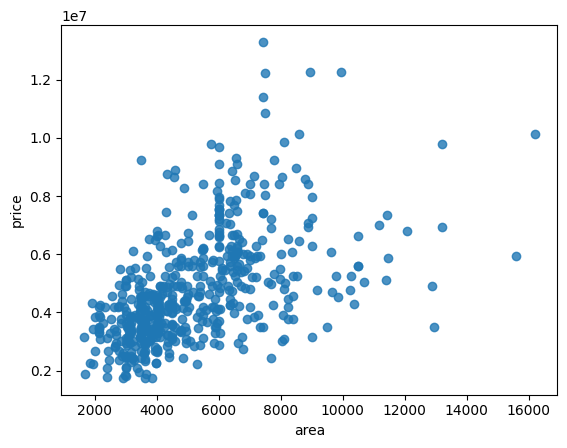

In [112]:
sns.regplot(x="area", y="price", data=df_uni_variate, fit_reg=False)

In [113]:
# Lets fit the model
x_train, x_test, y_train, y_test = train_test_split(\
    x, y,\
    test_size=0.3, 
    random_state=42)

In [114]:
first_model = LinearRegression()
first_model.fit(x_train, y_train)

LinearRegression()

### Train and test split, fit a linear regression model, and predict

In [115]:
print('Model Coefficients:', first_model.coef_)
print()
print('Intercept:', first_model.intercept_)
coef = pd.DataFrame(first_model.coef_.T, columns=['Coefficients'])
cols = pd.DataFrame(x.columns, columns=['Columns'])
joined = pd.concat([cols['Columns'], coef['Coefficients']], axis=1)
joined

Model Coefficients: [[6539453.96912652]]

Intercept: [3199049.0918963]


,Columns,Coefficients
0,area,6.539454e+06


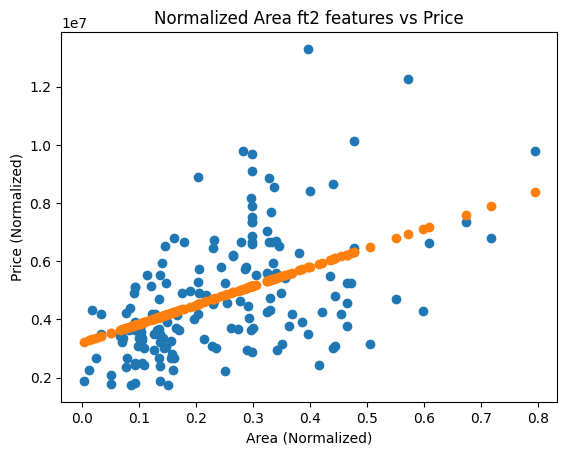

In [116]:
predictions = first_model.predict(x_test)
plt.scatter(x_test, y_test, label = "Actual labels")
plt.scatter(x_test, predictions, label = "Normalized predictions")
plt.title('Normalized Area ft2 features vs Price')
plt.xlabel('Area (Normalized)')
plt.ylabel('Price (Normalized)')
plt.show()

### Well... Univariate is not that great.
Lets now do multilinear regression analysis with the filtered data of each of the features!

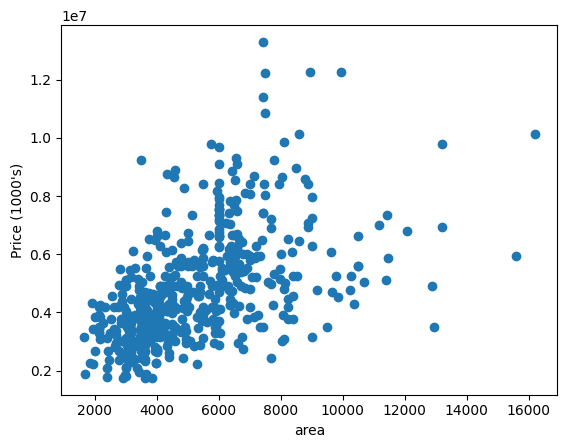

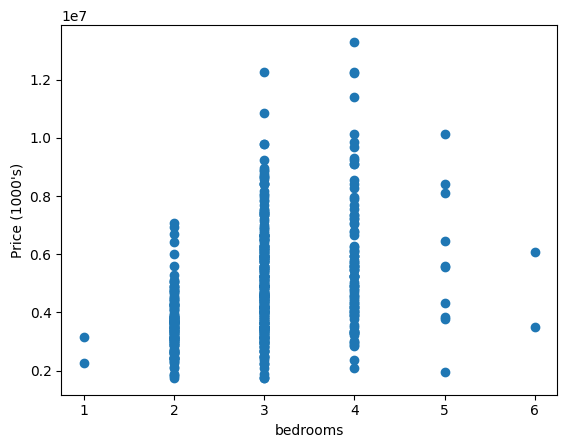

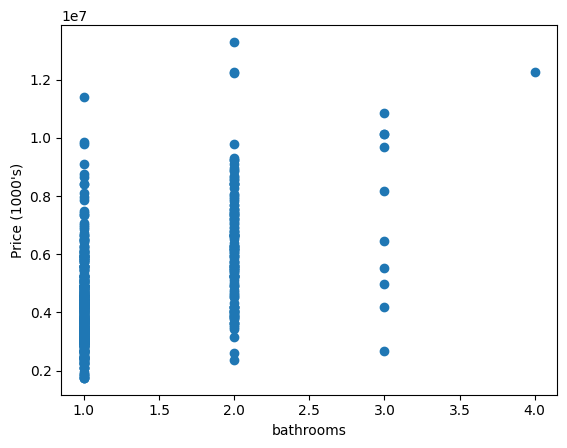

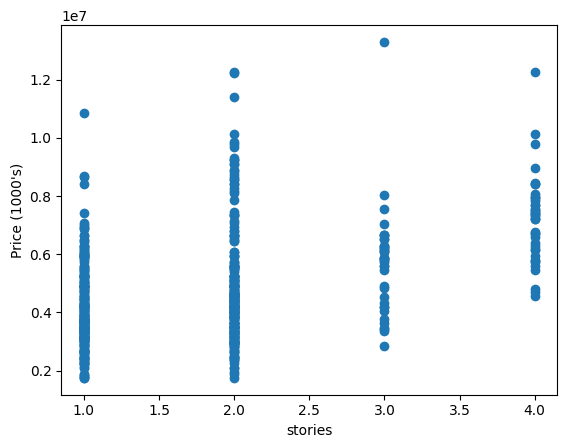

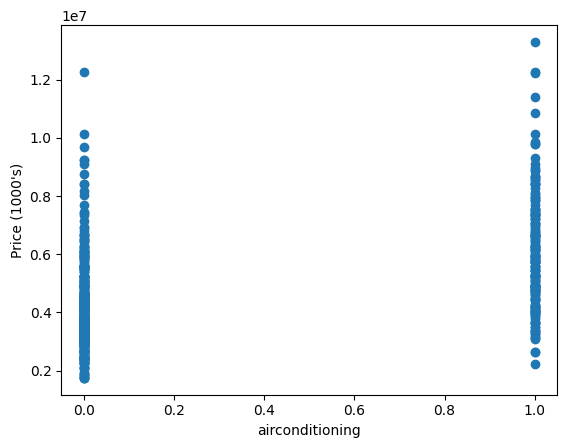

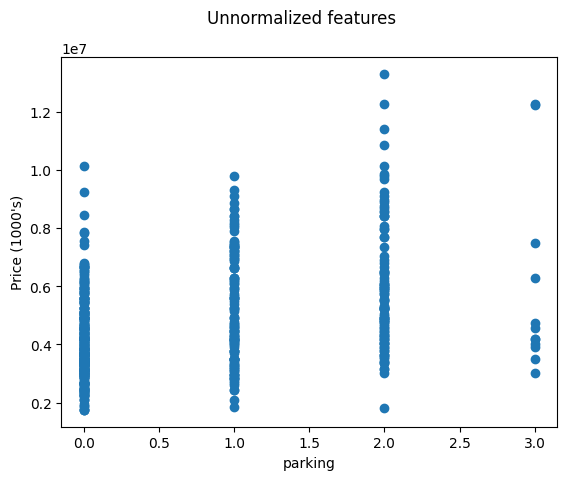

In [117]:
#Lets used the min-max feature scaled data
x = filtered_df.loc[:, filtered_df.columns != "price"]
y = pd.DataFrame(filtered_df["price"])
x_features = [x for x in filtered_df.columns if x != "price"]

for i in range(x.shape[1]):
    plt.figure()
    plt.scatter(x.iloc[:,i],y)
    plt.xlabel(x_features[i])
    plt.ylabel("Price (1000's)")
plt.suptitle("Unnormalized features")
plt.show()

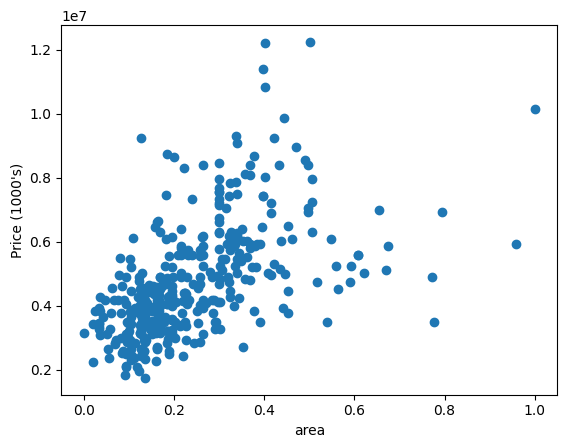

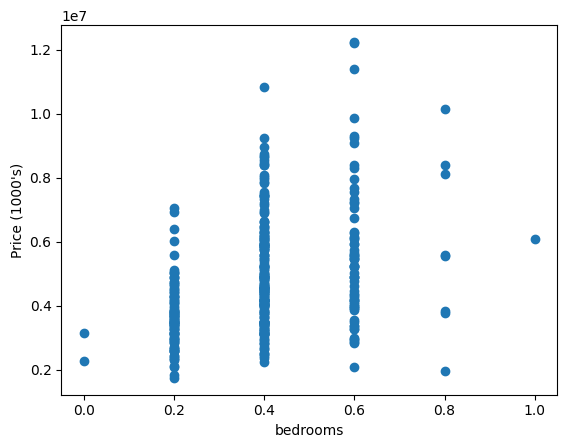

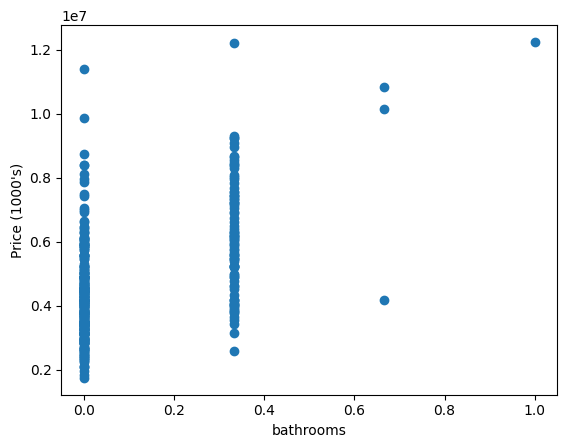

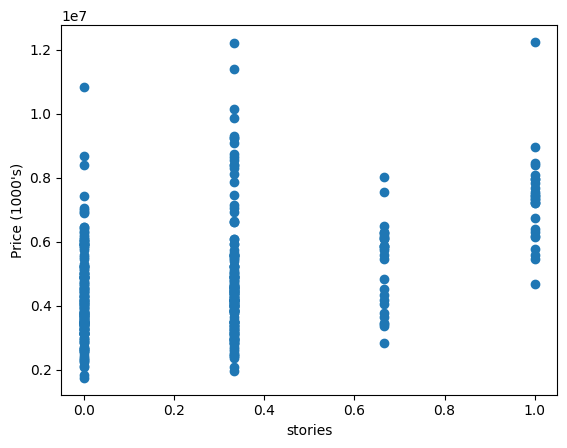

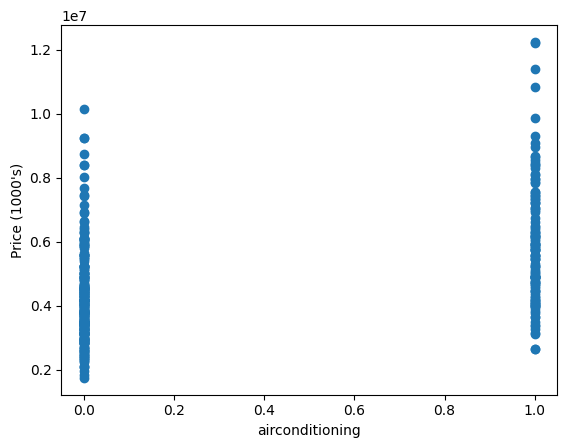

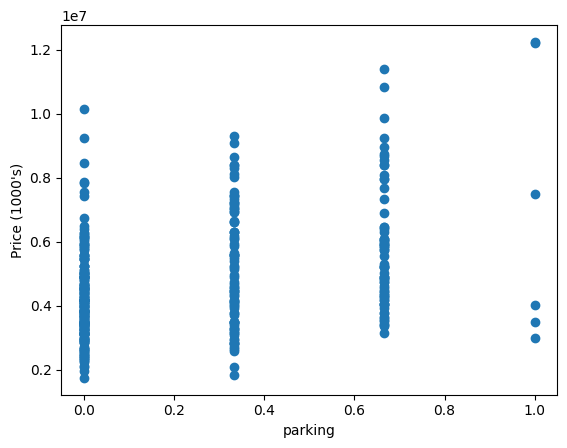

In [118]:
#Lets used the min-max feature scaled data
x = filtered_df.loc[:, filtered_df.columns != "price"]
y = pd.DataFrame(filtered_df["price"])
x_features = [x for x in filtered_df.columns if x != "price"]

#Plot the max feature scaled
df_columns = x.columns
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

# rename columns (since now its an np array)
x = pd.DataFrame(x)
x.columns = df_columns
x.head()

# Lets fit the model
x_train, x_test, y_train, y_test = train_test_split(\
    x, y,\
    test_size=0.3, 
    random_state=42)

for i in range(x_train.shape[1]):
    plt.figure()
    plt.scatter(x_train.iloc[:,i],y_train)
    plt.xlabel(x_features[i])
    plt.ylabel("Price (1000's)")
plt.show()

In [119]:
multi_model = LinearRegression()
multi_model.fit(x_train, y_train)

LinearRegression()

In [120]:
print('Model Coefficients:', multi_model.coef_)
print()
print('Intercept:', multi_model.intercept_)
coef = pd.DataFrame(multi_model.coef_.T, columns=['Coefficients'])
cols = pd.DataFrame(x.columns, columns=['Columns'])
joined = pd.concat([cols['Columns'], coef['Coefficients']], axis=1)
joined

Model Coefficients: [[4391305.02088619  673207.34206566 3474567.32759916 1062566.08381544
   791642.28616645 1055919.10800388]]

Intercept: [2380965.89892944]


,Columns,Coefficients
0,area,4.391305e+06
1,bedrooms,6.732073e+05
2,bathrooms,3.474567e+06
3,stories,1.062566e+06
4,airconditioning,7.916423e+05
5,parking,1.055919e+06


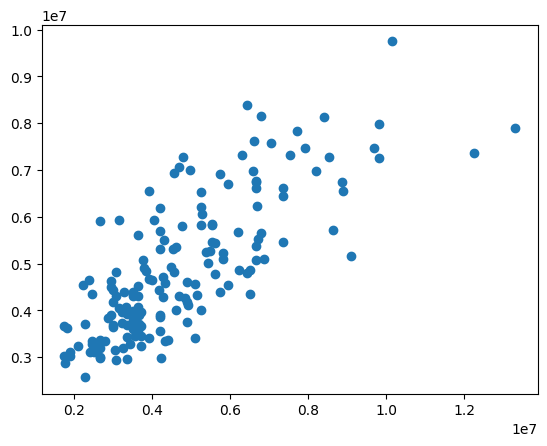

In [127]:
predictions = multi_model.predict(x_test)

plt.scatter(y_test, predictions, label = "Actual labels")
plt.show()